<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
pip install -U gensim

Requirement already up-to-date: gensim in /Users/Person/anaconda3/envs/NLP/lib/python3.7/site-packages (3.8.1)
Note: you may need to restart the kernel to use updated packages.


In [23]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

### When working with dataframes: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [5]:
# get stopwords
STOPWORDS = set(STOPWORDS).union(set(['batteries','I', 'amazon', 'i', 'Amazon', 'it', "it's", 'it.', 'the', 'this', ' ']))

In [6]:
# grab data and dataframe it
url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

df = pd.read_csv(url)
df.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [7]:
# To remove emails and newline characters: 
# Convert to list
data = df.full_review_text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

<>:6: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \s
<ipython-input-7-60024a6c435c>:6: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-7-60024a6c435c>:9: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


[' 11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes! I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? ']


In [8]:
# tokenize and clean the text
def sent_to_words(doc):
    for sentence in doc:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['check', 'in', 'love', 'love', 'loved', 'the', 'atmosphere', 'every', 'corner', 'of', 'the', 'coffee', 'shop', 'had', 'its', 'own', 'style', 'and', 'there', 'were', 'swings', 'ordered', 'the', 'matcha', 'latte', 'and', 'it', 'was', 'muy', 'fantastico', 'ordering', 'and', 'getting', 'my', 'drink', 'were', 'pretty', 'streamlined', 'ordered', 'on', 'an', 'ipad', 'which', 'included', 'all', 'beverage', 'selections', 'that', 'ranged', 'from', 'coffee', 'to', 'wine', 'desired', 'level', 'of', 'sweetness', 'and', 'checkout', 'system', 'got', 'my', 'latte', 'within', 'minutes', 'was', 'hoping', 'for', 'typical', 'heart', 'or', 'feather', 'on', 'my', 'latte', 'but', 'found', 'myself', 'listing', 'out', 'all', 'the', 'possibilities', 'of', 'what', 'the', 'art', 'may', 'be', 'any', 'ideas']]


In [9]:
# To create bigram and trigram models:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['check', 'in', 'love', 'love', 'loved', 'the', 'atmosphere', 'every', 'corner', 'of', 'the', 'coffee', 'shop', 'had', 'its', 'own', 'style', 'and', 'there', 'were', 'swings', 'ordered', 'the', 'matcha', 'latte', 'and', 'it', 'was', 'muy', 'fantastico', 'ordering', 'and', 'getting', 'my', 'drink', 'were', 'pretty', 'streamlined', 'ordered', 'on', 'an', 'ipad', 'which', 'included', 'all', 'beverage', 'selections', 'that', 'ranged', 'from', 'coffee', 'to', 'wine', 'desired', 'level', 'of', 'sweetness', 'and', 'checkout', 'system', 'got', 'my', 'latte', 'within', 'minutes', 'was', 'hoping', 'for', 'typical', 'heart', 'or', 'feather', 'on', 'my', 'latte', 'but', 'found', 'myself', 'listing', 'out', 'all', 'the', 'possibilities', 'of', 'what', 'the', 'art', 'may', 'be', 'any', 'ideas']


In [10]:
# To remove stopwords, make bigrams and lemmatize:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in STOPWORDS] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['check', 'love', 'love', 'love', 'atmosphere', 'corner', 'coffee', 'shop', 'style', 'swing', 'order', 'matcha', 'latte', 'order', 'get', 'drink', 'pretty', 'streamlined', 'order', 'ipad', 'include', 'beverage', 'selection', 'range', 'coffee', 'wine', 'desire', 'level', 'sweetness', 'checkout', 'get', 'latte', 'minute', 'hope', 'typical', 'heart', 'feather', 'latte', 'listing', 'possibility', 'art', 'idea']]


In [12]:
# To create the dictionary and corpus needed for topic modeling
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1), (18, 1), (19, 3), (20, 1), (21, 1), (22, 3), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)]]


"Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary." (source-link provided above)

In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('art', 1),
  ('atmosphere', 1),
  ('beverage', 1),
  ('check', 1),
  ('checkout', 1),
  ('coffee', 2),
  ('corner', 1),
  ('desire', 1),
  ('drink', 1),
  ('feather', 1),
  ('get', 2),
  ('heart', 1),
  ('hope', 1),
  ('idea', 1),
  ('include', 1),
  ('ipad', 1),
  ('latte', 3),
  ('level', 1),
  ('listing', 1),
  ('love', 3),
  ('matcha', 1),
  ('minute', 1),
  ('order', 3),
  ('possibility', 1),
  ('pretty', 1),
  ('range', 1),
  ('selection', 1),
  ('shop', 1),
  ('streamlined', 1),
  ('style', 1),
  ('sweetness', 1),
  ('swing', 1),
  ('typical', 1),
  ('wine', 1)]]

In [18]:
# To build the topic model:
# Build an LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
# To view the topics in the LDA model:
# Print the top 10 keywords in the 20 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

# output includes weights of each [key]word, 
#  reflecting their relative importance for each listed topic

[(0, '0.236*"vegan" + 0.109*"customer_service" + 0.069*"environment" + 0.044*"slightly" + 0.042*"frequent" + 0.035*"pro" + 0.033*"notch" + 0.029*"con" + 0.017*"hair" + 0.009*"remotely"'), (1, '0.209*"espresso" + 0.135*"brew" + 0.089*"updated_review" + 0.051*"establishment" + 0.044*"refreshing" + 0.035*"double" + 0.028*"overcook" + 0.019*"normally" + 0.017*"stumptown" + 0.016*"scratch"'), (2, '0.125*"vanilla" + 0.112*"mocha" + 0.076*"lavender" + 0.052*"venue" + 0.052*"almond_milk" + 0.051*"soy" + 0.047*"homemade" + 0.044*"efficient" + 0.042*"syrup" + 0.026*"rosemary"'), (3, '0.213*"night" + 0.175*"dessert" + 0.131*"today" + 0.061*"prepare" + 0.054*"delish" + 0.040*"cost" + 0.020*"rave" + 0.007*"penny" + 0.000*"sandwich" + 0.000*"salad"'), (4, '0.060*"price" + 0.051*"ask" + 0.046*"kind" + 0.034*"give" + 0.028*"leave" + 0.027*"choice" + 0.022*"pay" + 0.022*"high" + 0.022*"pick" + 0.021*"hear"'), (5, '0.174*"dish" + 0.114*"arrive" + 0.105*"face" + 0.075*"smile" + 0.061*"almond" + 0.039*"re

In [16]:
# To compute model perplexity and coherence scores:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence-Score
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=data_lemmatized,
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# they are measures of how good a topic model is; focus on coherence


Perplexity:  -12.302974308541332

Coherence Score:  0.37006197575747346


In [ ]:
# To visualize the keywords of topics:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

# Each bubble represents a topic, with its size related to 
#  the topic's prevalence. Good topic models should have distinct, 
#  large, unclustered  bubbles

In [29]:
# To find optimal number of topics (for LDA):
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                            corpus=corpus, 
                                            texts=data_lemmatized, 
                                            start=2, limit=40, step=6)

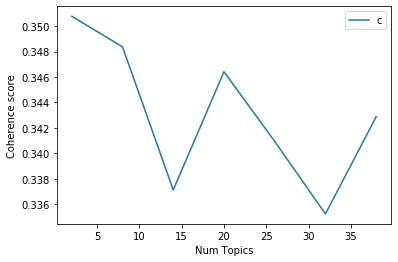

In [31]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
# Print coherence scores 
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3508
Num Topics = 8  has Coherence Value of 0.3484
Num Topics = 14  has Coherence Value of 0.3371
Num Topics = 20  has Coherence Value of 0.3464
Num Topics = 26  has Coherence Value of 0.3409
Num Topics = 32  has Coherence Value of 0.3352
Num Topics = 38  has Coherence Value of 0.3429


In [37]:
# Select best model from listing (here, it's the first model, with 2 topics)
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)

# output the topics of the selected LDA model
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.027*"coffee" + 0.024*"place" + 0.015*"not" + 0.014*"good" + 0.012*"be" + '
  '0.009*"check" + 0.009*"great" + 0.009*"do" + 0.008*"have" + 0.008*"order"'),
 (1,
  '0.034*"coffee" + 0.015*"good" + 0.013*"great" + 0.011*"place" + 0.011*"be" '
  '+ 0.010*"check" + 0.010*"not" + 0.008*"love" + 0.008*"come" + 0.008*"shop"')]


In [39]:
# To find dominant topic in each doc:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

# Feature Dominant_Topic tells which of the topics is most dominant
#  for a given document. In this case, as there are only two topics,
#  1.0 and 0.0 are the only listed values

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9802,"coffee, good, great, place, be, check, not, lo...",11/25/2016 1 check-in Love love loved the atm...
1,1,0.0,0.5608,"coffee, place, not, good, be, check, great, do...","12/2/2016 Listed in Date Night: Austin, Ambia..."
2,2,1.0,0.8901,"coffee, good, great, place, be, check, not, lo...",11/30/2016 1 check-in Listed in Brunch Spots ...
3,3,1.0,0.9608,"coffee, good, great, place, be, check, not, lo...",11/25/2016 Very cool decor! Good drinks Nice ...
4,4,1.0,0.9387,"coffee, good, great, place, be, check, not, lo...",12/3/2016 1 check-in They are located within ...


In [41]:
# To find the most representative document for each topic:
#  can be used to get a better idea of what a topic is 

# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9946,"coffee, place, not, good, be, check, great, do...","12/11/2014 DONT GO HERE! Please, for your own..."
1,1.0,0.9945,"coffee, good, great, place, be, check, not, lo...",6/6/2015 1 check-in Listed in Vegan in Austin...


In [43]:
sent_topics_sorteddf.Text[1] 
# Reading these two topics, one can make out that one is representative 
# of negative reviews while the other is representative of positive reviews

' 6/6/2015 1 check-in Listed in Vegan in Austin Vacation One thing I love about Austin is the friendly people. The friendliness of the servers at The Steeping Room definitely stood out! Not only was the service excellent, but the food and tea were also very delicious. It was a memorable experience and Im glad we got the chance to try it out before heading back to Cali. Luckily a couple of my friends in my group were tea connoisseurs so I let them choose the teas. My friend selected the Yame Gyokuro green tea and also the "Milk" Oolong. Both teas smelled heavenly and I really enjoyed the feeling of awareness I felt when sipped on them. I even brought some of lovely Yame Gyokuro home with me. As far as food, we decided to share everything. I love sharing with friends so we can try several dishes. Below is what we ordered: - Zen Tea Service - napa rolls with tofu/ walnut cucumber, edamame, matcha dusted vegan chocolate cupcake (subbed a vegan cupcake with the brownie). Loved the fresh rol

In [45]:
# To get the distribution of topics across documents:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts.sort_index(), topic_contribution.sort_index()], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"coffee, place, not, good, be, check, great, do...",2995,0.3933
1,1.0,"coffee, good, great, place, be, check, not, lo...",4621,0.6067


## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling